In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import seaborn as sns

In [3]:
import os
import sys

In [4]:
# chaging directory

In [5]:
root, *_ = !pwd

In [6]:
if root.endswith('notebooks'):
    os.chdir('../')
    root, *_ = !pwd
    sys.path.append('src/')

In [7]:
os.getcwd()

'/home/med/projects/competitions/mlb-kaggle'

In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
RAW_PATH = Path(os.environ['RAW_PATH'])

In [10]:
PROCESSED_PATH = Path(os.environ['ROOT_DIR']) / 'processed'

In [11]:
os.listdir(PROCESSED_PATH)

['target.csv', 'raw_data.csv']

In [12]:
os.listdir(RAW_PATH)

['seasons.csv',
 'teams.csv',
 'example_sample_submission.csv',
 'train.csv',
 'mlb-player-digital-engagement-forecasting.zip',
 'awards.csv',
 'players.csv',
 'example_test.csv',
 'mlb']

In [13]:
df = pd.read_csv(PROCESSED_PATH / 'raw_data.csv', parse_dates=['date'])

/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (84) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [14]:
df.head()

,playerId,target1,target2,target3,target4,date,target_avg,battingOrder,gamesPlayedBatting,flyOuts,...,assists,putOuts,errors,chances,rosterDate,teamId,status,numberOfFollowers,awardId,teamFollowers
0,112526,0.055277,5.496109,0.025839,16.176471,2018-01-01,5.438424,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,112526,0.060625,3.252914,0.030486,8.541353,2018-01-02,2.971345,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,112526,0.029341,1.648352,0.032613,10.490112,2018-01-03,3.050104,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,112526,0.014799,2.665894,0.087422,19.091467,2018-01-04,5.464896,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,112526,0.083916,1.161002,0.024759,6.643880,2018-01-05,1.978389,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### time and player data 

In [15]:
_players = pd.read_csv(RAW_PATH / 'players.csv')

In [16]:
_players['playerForTestSetAndFuturePreds'].fillna(False, inplace=True)

In [17]:
player_in_test = _players.query('playerForTestSetAndFuturePreds')['playerId']

### target 

In [18]:
from data.ingest_data import player_stats_features
from data.util import filter_by_id

In [19]:
df = filter_by_id(df, player_in_test)

In [20]:
playerList = df.groupby(['playerId'])['target_avg'].std().sort_values(ascending=False).reset_index()

In [21]:
playerList

,playerId,target_avg
0,547180,18.775985
1,660271,18.055585
2,545361,17.410036
3,605141,17.236386
4,592450,16.850044
...,...,...
1182,593590,0.119988
1183,656458,0.115664
1184,676424,0.094298
1185,641927,0.086976


In [22]:
# df = filter_by_id(df, playerList['playerId'].head(10))

# df.playerId.nunique()

### preprocessing 

In [23]:
from typing import List
def forward_fill(df: pd.DataFrame, features: List[str],
                 on='playerId',
                 limit: int =None):
    ffilled_df = df.groupby(on)[features].ffill(limit=limit)
    df.loc[:, features] = ffilled_df
    return df

In [24]:
def gen_hardcoded_features(df: pd.DataFrame):
    # some feature eng for the dates
    df['playerAge'] = (df['date'] - df['DOB']).dt.total_seconds()
    df['playerTSinceDebut'] = (df['date'] - df['mlbDebutDate']).dt.total_seconds()
    df['playerDebutAge'] = (df['mlbDebutDate'] - df['DOB']).dt.total_seconds()
    df['rostersTime'] = (df['date'] - pd.to_datetime(df['rosterDate'])).dt.total_seconds()
    df['rostersTime'] /= 60 * 60 * 24
    # normalize
    df[['playerAge', 'playerTSinceDebut', 'playerDebutAge']] /= 60 * 60 * 24 * 365
    df['AwardWinner'] = df['awardId'].isna().astype(np.float64)
    return df

In [25]:
def fillna(df: pd.DataFrame, fill_value=-1):
    return df.fillna(-1)

In [26]:
from pipeline.core import FunctionTransformer, Pipeline, PdColumnTransformer, PdFeatureUnion
from pipeline.continuous import PdScaleNorm, FilterContinuousFeatures, MedianFillNaN
from pipeline.stats import StatisticGen, LagGen, FeaturesTable
from pipeline.categories import Categorify
from pipeline.season import join_season_info
from pipeline.players import join_players_info

In [27]:
# from sklearn.base import BaseEstimator, TransformerMixin

# class StatsEncoding(BaseEstimator, TransformerMixin):
#     def __init__(self, on: List[str],
#                  stats: List[str] = ['mean'],
#                 dt_col: str = 'date'):
#         self.on = on
#         self.stats = stats
#         self.dt_col = dt_col
    
#     def fit(self, X: pd.DataFrame, y=None):    
#         features = X.columns.drop(self.on + [self.dt_col])
#         daily_features = X.groupby(self.on + [self.dt_col])[features].mean()
        
#         daily_features.reset_index(inplace=True)
#         daily_features.set_index(self.dt_col, inplace=True)
        
        
#         stats_table = (daily_features.groupby(self.on)[features].expanding()
#                       .agg(self.stats))
#         stats_table.columns = ['__'.join(list(f) + ['enc'] + self.on)
#                                for f in stats_table]
        
#         stats_table.reset_index(inplace=True)
#         self.stats_table = stats_table
#         self.max_date = X[self.dt_col].max().to_numpy()

#         return self


#     def transform(self, X: pd.DataFrame):
#         outputX = X.loc[:, self.on + [self.dt_col]].copy()
#         outputX.loc[:, self.dt_col] = np.minimum(outputX[self.dt_col], self.max_date)
        
#         outputX = outputX.merge(self.stats_table,
#                                 how='left',
#                                 on=self.on + [self.dt_col])

#         assert len(outputX) == len(X)
# #         print((X.loc[:, self.on + [self.dt_col]] == outputX.loc[:, self.on + [self.dt_col]]).all())
# #         assert (X.loc[:, self.dt_col] == outputX.loc[:, self.dt_col]).all()  
#         outputX.drop(self.on + [self.dt_col], axis=1, inplace=True)
        
#         return outputX


In [28]:
# transformer for joining data and create base features
fill_forward_tmf = FunctionTransformer(forward_fill, kw_args={'features':['numberOfFollowers',
                                                                        'teamFollowers',
                                                                        'status',
                                                                        'teamId',
                                                                          'rosterDate']})
join_season_tmf = FunctionTransformer(join_season_info,
                                      kw_args={'path_to_season': RAW_PATH / 'seasons.csv',
                                             'date_attr': ['year', 'month']})
join_players_tmf = FunctionTransformer(join_players_info, kw_args={'path_to_players': RAW_PATH / 'players.csv'})
harcoded_feat_tmf = FunctionTransformer(gen_hardcoded_features)

In [29]:
# creating pipeline
join_and_compute_feat_pl = Pipeline([('season', join_season_tmf),
                                     ('players', join_players_tmf),
                                     ('fill_forward', fill_forward_tmf),
                                     ('hardcoded_feat', harcoded_feat_tmf)])

In [30]:
# features to use for target preprocessing
target_cols = ['target1', 'target2', 'target3', 'target4']
index_cols = ['date', 'playerId']
pp_cols = target_cols + index_cols

In [31]:
# categories encoding
categories = ['playerId', 'seasonPart', 'year',
              'primaryPositionName', 'month', 'status', 'teamId', 'awardId']

categories_tmf = PdColumnTransformer([(category, Categorify(add_nan=True), category)
                                       for category in categories])

In [32]:
# # mean, median, std categories encoding
# stats_enc_categories = [ ['seasonPart'],
#                          ['teamId', 'seasonPart'],
#                          ['teamId']]
# enc_stats = ['mean', 'std', 'median']

# stats_enc_tmf = PdColumnTransformer([('_'.join(stats_enc_cat),
#                                               StatsEncoding(on=stats_enc_cat, stats=enc_stats),
#                                               stats_enc_cat + ['date'] + target_cols)
#                                               for stats_enc_cat in stats_enc_categories])

# stats_enc_pipeline = Pipeline([('compute_stats', stats_enc_tmf),
#                                ('fillnan', FunctionTransformer(fillna)),
#                               ('normalize', PdScaleNorm())])

In [33]:
def merge_table(X: pd.DataFrame, table: pd.DataFrame, on: List[str], drop_on: bool = True):
    outputX = X.loc[:, on].copy()
    outputX = outputX.merge(table, on=on, how='left')
    assert len(outputX) == len(X), \
               f'the len {len(X)} of the input do not match the output len {len(outputX)}'
    if drop_on:
        outputX.drop(on, axis=1, inplace=True)
    return outputX
    

In [34]:
def generate_cluster(df: pd.DataFrame,
                     cluster: List[str],
                     features: List[str] = target_cols,
                     dt_col: str = 'date'):
    _cluster = cluster + [dt_col]

    cluster_features = df.groupby(_cluster)[features].mean()
    cluster_features.columns = ['__'.join([f] + cluster)
                                for f in cluster_features.columns]
    cluster_features.reset_index(inplace=True)
    return cluster_features
    

def cluster_statistics(df: pd.DataFrame,
                       cluster: List[str],
                       features: List[str],
                       windows: List[int],
                       stats: List[str] = ['mean', 'median', 'std'],
                       dt_col: str = 'date'):
    cluster_df = generate_cluster(df, cluster, features=features, dt_col=dt_col)
    stats_tmf = StatisticGen(stats=stats, windows=windows, ids=cluster, drop_index=False)
    cluster_rolling_stats = stats_tmf.fit_transform(cluster_df)
    return merge_table(df, cluster_rolling_stats, on=cluster + [dt_col], drop_on=True)

In [37]:
### compute stats
stats_gen_tmf = StatisticGen(stats=['mean', 'median', 'std'], windows=[90], drop_index=False)


cluster_features = [['teamId'],
                    ['primaryPositionName'],
                    ['teamId', 'primaryPositionName'],
                    ['seasonPart', 'teamId']]

cluster_tmf = [('_'.join(cluster), FunctionTransformer(cluster_statistics,
                                                        kw_args={'cluster': cluster,
                                                                 'features': target_cols,
                                                                 'windows': [90]}))
               for cluster in cluster_features]
target_stats_tmf = PdColumnTransformer([('gen_stats', stats_gen_tmf, pp_cols)])

### compute 
target_stats_pipeline = Pipeline([('join', join_and_compute_feat_pl),
                                 ('stats', PdFeatureUnion([('stats', target_stats_tmf)] + cluster_tmf))])

target_stats_table = target_stats_pipeline.fit_transform(df)


In [38]:
target_stats_table.head()

,playerId,date,target1__mean__90d,target1__median__90d,target1__std__90d,target2__mean__90d,target2__median__90d,target2__std__90d,target3__mean__90d,target3__median__90d,...,target1__seasonPart__teamId__std__90d,target2__seasonPart__teamId__mean__90d,target2__seasonPart__teamId__median__90d,target2__seasonPart__teamId__std__90d,target3__seasonPart__teamId__mean__90d,target3__seasonPart__teamId__median__90d,target3__seasonPart__teamId__std__90d,target4__seasonPart__teamId__mean__90d,target4__seasonPart__teamId__median__90d,target4__seasonPart__teamId__std__90d
0,405395,2018-01-01,0.151872,0.151872,NaN,21.449417,21.449417,NaN,0.112952,0.112952,...,NaN,7.574038,7.574038,NaN,3.580662,3.580662,NaN,4.637800,4.637800,NaN
1,405395,2018-01-02,0.144139,0.144139,0.010936,16.214001,16.214001,7.403996,0.104677,0.104677,...,0.006905,5.533201,5.533201,2.886179,2.194412,2.194412,1.960454,3.852734,3.852734,1.110250
2,405395,2018-01-03,0.117580,0.136406,0.046648,13.884730,10.978585,6.609544,0.103606,0.101464,...,0.027047,4.840697,3.492365,2.367214,2.914943,3.580662,1.865258,5.173502,4.637800,2.418597
3,405395,2018-01-04,0.094239,0.100433,0.060248,12.956289,10.574775,5.707194,0.103317,0.101956,...,0.653492,4.520764,3.526665,2.035984,3.373710,3.968334,1.778012,5.893120,6.226418,2.443592
4,405395,2018-01-05,0.106902,0.136406,0.059365,11.223893,10.170965,6.279732,0.091957,0.101464,...,0.574630,3.981075,3.492365,2.136642,2.753822,3.580662,2.071788,5.160982,4.637800,2.675535


In [39]:
## merge computed statistics
stats_feat_tmf = Pipeline([('lag_stats', FeaturesTable(target_stats_table, lags=[60], clip_max=True)),
                                                        ('fillnan', FunctionTransformer(fillna)),
                             ('normalize', PdScaleNorm())
                          ])

In [40]:
# continuous preprocessing

median_fillnan_columns = ['numberOfFollowers', 'teamFollowers',
                          'playerDebutAge', 'playerAge', 'playerTSinceDebut']
fillnan_median_tmf = MedianFillNaN(median_fillnan_columns)

# get the rest of the continuous features
continuous_feat_tmf = Pipeline([('get_cont_feat', FilterContinuousFeatures()),
                                ('fillnan_median', fillnan_median_tmf),
                                ('fillnan', FunctionTransformer(fillna)),
                                ('normalize', PdScaleNorm())
                               ])

In [41]:
# putting all together
all_features_tmf = PdFeatureUnion([('target_stats', stats_feat_tmf), 
                                   ('cont_feat', continuous_feat_tmf), 
                                  ('cats', categories_tmf),
                             #     ('cat_enc', stats_enc_pipeline),
                                  ])

In [42]:
# main pipeline with all steps 
pipeline = Pipeline([('join_compute', join_and_compute_feat_pl),
                    ('features_gen', all_features_tmf)])

In [43]:
pipeline

Pipeline(steps=[('join_compute',
                 Pipeline(steps=[('season',
                                  FunctionTransformer(func=<function join_season_info at 0x7f1d533de0d0>,
                                                      kw_args={'date_attr': ['year',
                                                                             'month'],
                                                               'path_to_season': PosixPath('data/raw/seasons.csv')})),
                                 ('players',
                                  FunctionTransformer(func=<function join_players_info at 0x7f1d533de1f0>,
                                                      kw_args={'path_to_players': PosixPath('data/raw/playe...
                                                                                     ('seasonPart',
                                                                                      Categorify(add_nan=True),
                                                   

In [44]:
from data.split import SplitData

In [45]:
sp = SplitData("2021-03-01", test_days=61)

In [46]:
train_idx = sp.train_idx(df)
valid_idx = sp.valid_idx(df)

In [47]:
%%time
pipeline.fit(sp.filter(df, train_idx))

CPU times: user 9.89 s, sys: 5.67 s, total: 15.6 s
Wall time: 15.8 s


Pipeline(steps=[('join_compute',
                 Pipeline(steps=[('season',
                                  FunctionTransformer(func=<function join_season_info at 0x7f1d533de0d0>,
                                                      kw_args={'date_attr': ['year',
                                                                             'month'],
                                                               'path_to_season': PosixPath('data/raw/seasons.csv')})),
                                 ('players',
                                  FunctionTransformer(func=<function join_players_info at 0x7f1d533de1f0>,
                                                      kw_args={'path_to_players': PosixPath('data/raw/playe...
                                                                                     ('seasonPart',
                                                                                      Categorify(add_nan=True),
                                                   

In [48]:
%%time
features = pipeline.transform(df)

CPU times: user 9.25 s, sys: 7.2 s, total: 16.4 s
Wall time: 16.6 s


In [49]:
pd.options.display.max_rows = 100
features.T.head(100)

,0,1,2,3,4,5,6,7,8,9,...,1443382,1443383,1443384,1443385,1443386,1443387,1443388,1443389,1443390,1443391
target1__mean__90d__60lag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.010039
target1__median__90d__60lag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901
target1__std__90d__60lag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013988,0.013988,0.013988,0.013988,0.013988,0.013988,0.013988,0.013988,0.013988,0.015834
target2__mean__90d__60lag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.034109,0.034958,0.035451,0.036231,0.037068,0.037560,0.038146,0.038372,0.039265,0.043983
target2__median__90d__60lag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.016995,0.017435,0.018050,0.019155,0.019931,0.020055,0.020147,0.020199,0.020360,0.020619
target2__std__90d__60lag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.142368,0.142651,0.142614,0.142790,0.143131,0.143067,0.143045,0.142944,0.143191,0.162586
target3__mean__90d__60lag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011419,0.011553,0.011627,0.011647,0.011654,0.011662,0.011668,0.011678,0.011679,0.012058
target3__median__90d__60lag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901,0.009901
target3__std__90d__60lag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.031189,0.031322,0.031348,0.031345,0.031343,0.031340,0.031338,0.031335,0.031335,0.032552
target4__mean__90d__60lag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.024905,0.024900,0.024930,0.024809,0.024600,0.024678,0.024702,0.024691,0.024689,0.024862


In [50]:
continuous_feat = features.columns.drop(categories)

In [51]:
df[target_cols] = df[target_cols].astype(np.float32)

In [52]:
train_idx.shape

(1443392,)

In [53]:
train_idx.shape

(1443392,)

In [54]:
train_data = sp.filter(features, train_idx)

In [55]:
raw_train_df = sp.filter(df, train_idx)

In [56]:
valid_data = sp.filter(features, valid_idx)
raw_valid_df = sp.filter(df, valid_idx)

In [57]:
train_data.shape, raw_valid_df.shape

((1370985, 151), (72407, 86))

In [58]:
valid_data.shape, raw_train_df.shape

((72407, 151), (1370985, 86))

In [59]:
train_data[target_cols + ['date']] = raw_train_df[target_cols + ['date']]
valid_data[target_cols + ['date']] = raw_valid_df[target_cols + ['date']]

### modeling 

In [60]:
time_features = ['battingOrder', 'gamesPlayedBatting', 'flyOuts', 'groundOuts',
       'runsScored', 'doubles', 'triples', 'homeRuns', 'strikeOuts',
       'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch', 'atBats',
       'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

In [61]:
static_features = list(features.columns.drop(categories + time_features))

In [62]:
static_features

['target1__mean__90d__60lag',
 'target1__median__90d__60lag',
 'target1__std__90d__60lag',
 'target2__mean__90d__60lag',
 'target2__median__90d__60lag',
 'target2__std__90d__60lag',
 'target3__mean__90d__60lag',
 'target3__median__90d__60lag',
 'target3__std__90d__60lag',
 'target4__mean__90d__60lag',
 'target4__median__90d__60lag',
 'target4__std__90d__60lag',
 'target1__teamId__mean__90d__60lag',
 'target1__teamId__median__90d__60lag',
 'target1__teamId__std__90d__60lag',
 'target2__teamId__mean__90d__60lag',
 'target2__teamId__median__90d__60lag',
 'target2__teamId__std__90d__60lag',
 'target3__teamId__mean__90d__60lag',
 'target3__teamId__median__90d__60lag',
 'target3__teamId__std__90d__60lag',
 'target4__teamId__mean__90d__60lag',
 'target4__teamId__median__90d__60lag',
 'target4__teamId__std__90d__60lag',
 'target1__primaryPositionName__mean__90d__60lag',
 'target1__primaryPositionName__median__90d__60lag',
 'target1__primaryPositionName__std__90d__60lag',
 'target2__primaryPosi

In [63]:
# from omegaconf import OmegaConf
# hp = {'bptt': 7,
#       'epochs': 10,
#       'batch_size': 2048,
#       'max_emb_sz': 20,
#       'hidden_dim': 32,
#       'encoder_dim': 128,
#       'emb_dropout': 0.2,
#       'dropout': 0.2,
#       'lr': 0.001,
#       'wd': 3e-5}

# lstm_config = {'hp': hp,
#                     'seed': 2021,
#          'static_features': static_features,
#           'categories': categories,
#           'time_features': time_features,
#           'target_cols': target_cols}
# lstm_config = OmegaConf.create(lstm_config) 

In [64]:
from train.lgbm import run_lgbm

In [81]:
from omegaconf import OmegaConf

parameters = {
#  'objective':'mae',
 'reg_alpha': 0.1,
 'reg_lambda': 0.1, 
 'n_estimators': 100000,
 'learning_rate': 0.1,
 'random_state': 42,
}
config = {'hp': parameters,
          'features': categories + static_features + time_features,
          'categories': categories,
          'target_cols': target_cols}
config = OmegaConf.create(config)

In [82]:
output = run_lgbm(config, train_data, valid_data)

target1


/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['awardId', 'month', 'playerId', 'primaryPositionName', 'seasonPart', 'status', 'teamId', 'year']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/med/anaconda3/envs/mlb/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 31.536
[200]	valid_0's l2: 31.3131
Early stopping, best iteration is:
[192]	valid_0's l2: 31.3016
target2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 57.5576
Early stopping, best iteration is:
[46]	valid_0's l2: 56.7713
target3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 38.1012
Early stopping, best iteration is:
[28]	valid_0's l2: 37.8617
target4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 26.1139
[200]	valid_0's l2: 25.8219
Early stopping, best iteration is:
[182]	valid_0's l2: 25.7986


In [83]:
from evaluate.metrics import compute_metrics

with best 500 ids 
one day lag

{'mae_mean': 15.404842,
 'mae_1': 15.112363,
 'mae_2': 12.518346,
 'mae_3': 15.941521,
 'mae_4': 18.04714}
 
{'mae_mean': 16.107979,
 'mae_1': 14.4299965,
 'mae_2': 13.712786,
 'mae_3': 17.216927,
 'mae_4': 19.072205}
 
lag 60 day 150 stats mean median std
raw_valid_df

{'mae_mean': 16.526415,
 'mae_1': 15.134252,
 'mae_2': 15.736391,
 'mae_3': 16.731949,
 'mae_4': 18.503065}
 
{'mae_mean': 16.243195,
 'mae_1': 14.64544,
 'mae_2': 15.223519,
 'mae_3': 16.67205,
 'mae_4': 18.43177}
 
 
with best 500 ids 
one day lag 
{'mae_mean': 2.4375365,
 'mae_1': 2.2795138,
 'mae_2': 3.1164076,
 'mae_3': 1.6708878,
 'mae_4': 2.6833365}
 
{'mae_mean': 3.2938020082107333,
 'mae_1': 2.5740078375938165,
 'mae_2': 5.631358953836824,
 'mae_3': 1.837284798457624,
 'mae_4': 3.1325564429546677}
 
lag 60 day 150 stats mean median std

{'mae_mean': 2.8213322,
 'mae_1': 2.4738746,
 'mae_2': 3.9536836,
 'mae_3': 1.8413752,
 'mae_4': 3.0163958}
 
{'mae_mean': 2.8054446768310446,
 'mae_1': 2.4669433853402922,
 'mae_2': 3.901420425393473,
 'mae_3': 1.8396196560640896,
 'mae_4': 3.0137952405263246}
 
 con toda la data
 
 {'mae_mean': 1.5619345,
 'mae_1': 1.2107118,
 'mae_2': 2.4501314,
 'mae_3': 0.95569867,
 'mae_4': 1.6311963}
 
 
 {'mae_mean': 1.5390999144452775,
 'mae_1': 1.210369386168515,
 'mae_2': 2.3818660584590656,
 'mae_3': 0.9496059085908733,
 'mae_4': 1.6145583045626561}
 

no propating forward
{'mae_mean': 1.6181669660843265,
 'mae_1': 1.2681040951665854,
 'mae_2': 2.542929024032986,
 'mae_3': 0.9624048148661487,
 'mae_4': 1.699229930271586}

In [84]:
valid_test_prediction = pd.DataFrame(output.prediction, columns=['yhat1', 'yhat2', 'yhat3', 'yhat4'])

valid_test_prediction[pp_cols] = raw_valid_df[pp_cols]

In [85]:
is_test_pred = valid_test_prediction['date'] >= '2021-04-01'

valid_prediction, test_prediction = (valid_test_prediction.loc[~is_test_pred, :],
                                     valid_test_prediction.loc[is_test_pred, :])

In [86]:
compute_metrics(valid_test_prediction)

{'mae_mean': 2.184621445753046,
 'mae_1': 1.6107178266596884,
 'mae_2': 3.661553502634797,
 'mae_3': 1.7739692007141634,
 'mae_4': 1.6922452530035348}

In [87]:
compute_metrics(valid_prediction)

{'mae_mean': 2.4263919779638843,
 'mae_1': 1.7930383995942711,
 'mae_2': 4.248523333763755,
 'mae_3': 1.9325005027755298,
 'mae_4': 1.731505675721981}

In [88]:
compute_metrics(test_prediction)

{'mae_mean': 1.9347918958018466,
 'mae_1': 1.4223199012939534,
 'mae_2': 3.055018010468207,
 'mae_3': 1.6101535219174186,
 'mae_4': 1.6516761495278067}

{'mae_mean': 8.744398122453422,
 'mae_1': 8.91478917325309,
 'mae_2': 8.77152911391691,
 'mae_3': 7.268066076937021,
 'mae_4': 10.023208125706667}


{'mae_mean': 7.778629376660697,
 'mae_1': 7.032324510699994,
 'mae_2': 9.003801645329068,
 'mae_3': 6.445435023328167,
 'mae_4': 8.632956327285559}

{'mae_mean': 8.269542728999648,
 'mae_1': 7.989123162641596,
 'mae_2': 8.885384394035018,
 'mae_3': 6.863603225531401,
 'mae_4': 9.34006013379057}

In [89]:
def plot_pred(df, playerId, index=1):
    pdf = df.query(f'playerId == {playerId}')
    
    f, ax = plt.subplots(1, 1, figsize=(20, 5))
    
    tname = f'target{index}'
    yhat_name = f'yhat{index}'
    
    ax.plot('date', tname, '-o', data=pdf, label=tname)
    ax.plot('date', yhat_name, '-o', data=pdf, label=tname)
    
    ax.legend()
    

In [90]:
def feature_importance(features, model):
    fi = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
    fi.sort_values(by='importance', ascending=False, inplace=True)
    return fi

def compute_fi(features, models):
    fi = [feature_importance(features, _model).assign(target=f'target{target}')
      for target, _model in enumerate(models)]
    fi = pd.concat(fi)
    fi = fi.pivot('feature', 'target', 'importance')
    fi = fi * 100 / fi.sum()
    fi['mean'] = fi.mean(axis=1)
    fi.sort_values(by='mean', ascending=False, inplace=True)
    return fi

In [91]:
fi = compute_fi(config.features, output.model)

In [92]:
fi.head(100)

target,target0,target1,target2,target3,mean
feature,,,,,
playerId,14.878472,42.681159,30.357143,20.494505,27.102820
month,2.986111,8.188406,6.190476,4.304029,5.417256
rostersTime,1.388889,4.057971,6.547619,2.783883,3.694590
teamId,1.927083,1.739130,4.642857,1.794872,2.525986
totalBases,1.875000,3.333333,2.738095,1.153846,2.275069
seasonPart,0.746528,5.362319,1.309524,1.465201,2.220893
rbi,2.482639,0.869565,3.690476,0.549451,1.898033
homeRuns,1.406250,0.724638,2.857143,0.695971,1.421000
target3__median__90d__60lag,1.076389,0.942029,2.261905,1.263736,1.386015


In [93]:
(valid_prediction.groupby('playerId')
 .apply(lambda x: pd.Series(compute_metrics(x)))
 .sort_values(by='mae_mean', ascending=False)).head(10)

,mae_mean,mae_1,mae_2,mae_3,mae_4
playerId,,,,,
660271,25.713147,24.911614,31.323918,24.991701,21.625353
596019,23.628363,29.793367,17.017431,24.224886,23.477770
592626,18.046924,22.078043,28.870469,7.166319,14.072866
665487,17.751858,21.673968,8.317757,23.979872,17.035834
545333,16.999936,20.316067,14.735212,13.773290,19.175175
545361,16.893376,13.785153,13.048404,14.326532,26.413417
666915,14.880468,15.238676,23.824266,12.564989,7.893940
605141,14.381047,12.368628,11.287423,11.203271,22.664865
547180,14.000630,14.715562,12.220791,8.501994,20.564175


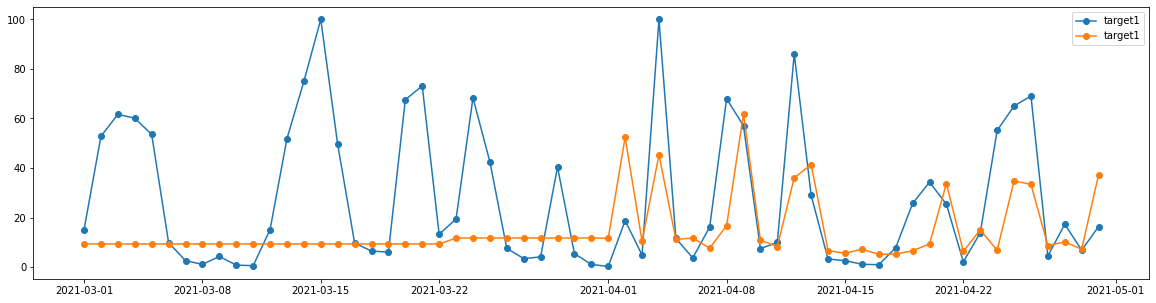

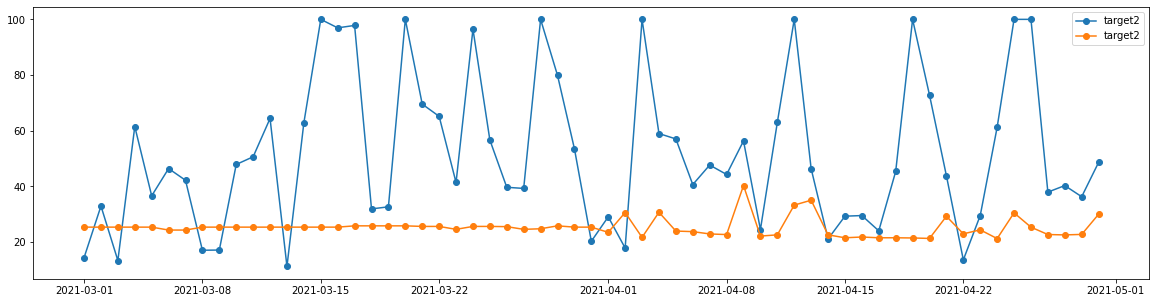

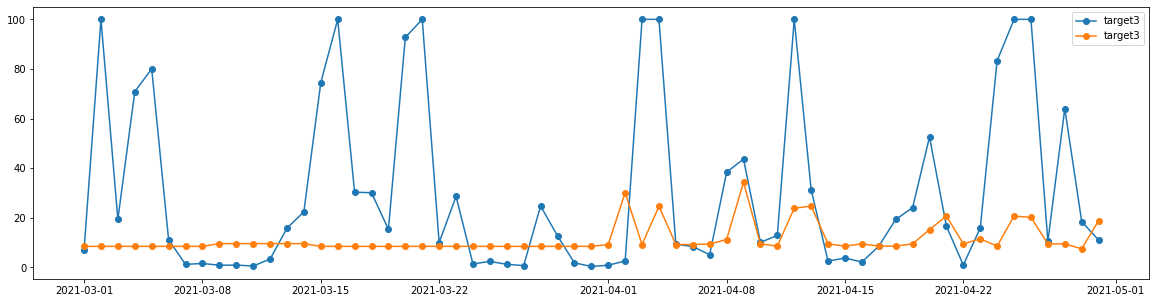

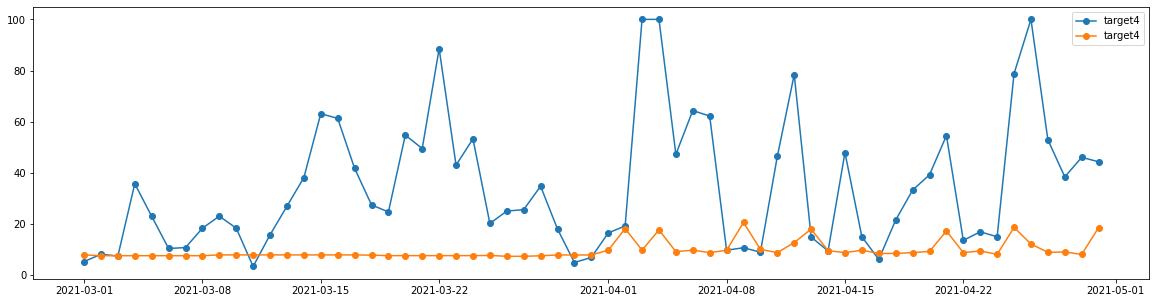

In [95]:
for index in range(1, 5):
    plot_pred(valid_test_prediction, playerId=660271, index=index)

In [77]:
# del train_data, valid_data, target, features #df, raw_train_df, raw_valid_df

In [78]:
# import gc
# gc.collect()